# Task 2: Evaluation of an object detector

Evaluate the given results of the object detector. Use 𝝀 = 𝟎. 𝟓 to provide the following:

* Provide the BEV images including the BBs (groundtruth and detection, use green and red respectively) with all IoUs as seen on the right for all 20 scenes.
* Provide the recall and the precision for each scene.

#### 1- Importing of Libraries.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import cmath
from shapely.geometry import Polygon
import warnings
warnings.filterwarnings("ignore")

#### 2- Declaring constant values.

In [8]:
#Directory of the files:
bev_dir = "KITTI\bev"
img_dir = "KITTI\images"
lbl_dir = "KITTI\labels"
prd_dir = "KITTI\predictions"

# Set the directory path
base_path = 'KITTI'
bevs_path = os.path.join(base_path, 'bev')
labels_path = os.path.join(base_path, 'labels')
preds_path = os.path.join(base_path,"predictions")
labels_output_path = os.path.join(base_path, 'labels_output')
full_output_path = os.path.join(base_path,"full_output")

#### 3- Defining the function for calculating the Intersection over Union(IoU).

In [4]:
def calculate_iou(rect1, rect2):
    # Convert OpenCV rectangles into Polygons from Shapely.
    polygon1 = Polygon(rect1)
    polygon2 = Polygon(rect2)

    # Calculate intersection area
    intersection_area = polygon1.intersection(polygon2).area
    # Calculate union area
    union_area = polygon1.union(polygon2).area
    # Calculate IoU
    iou = intersection_area / union_area

    return iou

#### 4- The main Algorithm.

In [10]:
#Iterate over the BEV files.
for bev_file in os.listdir(bevs_path):
    #get the according path for the BEV, label and prediction files.
    bev_path = os.path.join(bevs_path, bev_file)
    bev_image = cv2.imread(bev_path)

    label_filename = bev_file.replace('.png', '.csv')
    label_path = os.path.join(labels_path, label_filename)

    pred_filename = bev_file.replace('.png', '.csv')
    pred_path = os.path.join(preds_path, pred_filename)
    
    number_of_labels = 0
    number_of_bigger_values = 0 
    rect_points_list_label = []
    #Iterate over the according label file.
    label_df = pd.read_csv(label_path, header=None, names=['class', 'x', 'y', 'w', 'l', 'im', 're'])
    for label_index, label_row in label_df.iterrows():
        label_class_id = int(label_row['class'])
        if(label_class_id == 0):
            number_of_labels += 1
            label_x = float(label_row['x'])
            label_y = float(label_row['y'])
            label_w = float(label_row['w'])
            label_l = float(label_row['l'])
            label_im = float(label_row['im'])
            label_re = float(label_row['re'])
            #Turn the imaginary and real values of the rotation into an angle.
            label_angle = np.degrees(cmath.phase(complex(label_re, label_im)))   

            #Create rotated rectangle contour for the label.
            rect_points_label = cv2.boxPoints(((label_x,label_y), (label_w, label_l), label_angle))  
            rect_points_label = np.intp(rect_points_label)
            #Save the label rects for later writing over the image.
            rect_points_list_label.append(rect_points_label)

            rect_points_list_pred = []
            number_of_predictions = 0
            #Iterate over the according prediction file.
            pred_df = pd.read_csv(pred_path, header=None, names=['x', 'y', 'w', 'l', 'im', 're','object_conf','class_score','class_pred'])
            for pred_index, pred_row in pred_df.iterrows():
                pred_class_pred = int(pred_row['class_pred'])
                if(pred_class_pred == 0):
                    number_of_predictions += 1
                    pred_x = float(pred_row['x'])
                    pred_y = float(pred_row['y'])
                    pred_w = float(pred_row['w'])
                    pred_l = float(pred_row['l'])
                    pred_im = float(pred_row['im'])
                    pred_re = float(pred_row['re'])
                    pred_object_conf = float(pred_row['object_conf'])
                    pred_class_score = float(pred_row['class_score'])
                    #Turn the imaginary and real values of the rotation into an angle.
                    pred_angle = np.degrees(cmath.phase(complex(pred_re, pred_im)))

                    # Create rotated rectangle contour for the prediction.
                    rect_points_pred = cv2.boxPoints(((pred_x,pred_y), (pred_w, pred_l), pred_angle))  
                    rect_points_pred = np.intp(rect_points_pred)

                    #Save the rects of the predictions for calculation of IoUs.
                    rect_points_list_pred.append(rect_points_pred)
                    #Draw the contours of the predicition.
                    cv2.drawContours(bev_image, [rect_points_pred], 0, (0,0,255), 2)

            #Draw the contours for the labels.
            for rect_points_label in rect_points_list_label:
                cv2.drawContours(bev_image, [rect_points_label], 0, (0, 255, 0), 2)

            #Calculate the IoU for each label.
            IoU_list = []
            for rect in rect_points_list_pred:
                iou_value = calculate_iou(rect_points_label,rect)
                IoU_list.append(iou_value)

            #Get the IoU values that are bigger than the threshold.
            bigger_values_list = []
            for i in IoU_list:
                if i>0.5:
                    bigger_values_list.append(i)    

            #Get the number and the maximum values of the values that are over the threshold.
            number_of_bigger_values += len(bigger_values_list)
            if len(bigger_values_list) != 0:
                biggest_value = (max(bigger_values_list))
            else:
                bigger_values_list = [0,0]
                biggest_value = 0

            #Add the IoU value next to the bounding box.
            biggest_value_str = str(round(biggest_value,2))
            M = cv2.moments(rect_points_label)
            centroid_x, centroid_y = int(M["m10"] / M[ "m00"]), int(M["m01"] / M["m00"])
            text_position = (centroid_x +20, centroid_y - 20)
            if(biggest_value != 0):
                cv2.putText(bev_image, biggest_value_str, text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    #Calculate the TP,FP and FN values.
    TP = number_of_bigger_values
    FP = number_of_predictions - number_of_bigger_values
    FN = 0
    if(TP>number_of_labels):
        TP = number_of_labels
    else:
        TP = number_of_bigger_values
        FN = number_of_labels - TP
    
    #Calculate the Recall and Precision:
    recall_denominator = TP + FN
    if recall_denominator > 0:
        recall = TP / recall_denominator
        recall_str = f"Recall: {round(recall, 2)}" 
    else:
        precision_str = "Recall: null"

    precision_denominator = TP + FP
    if precision_denominator > 0:
        precision = TP / precision_denominator
        precision_str = f"Precision: {round(precision, 2)}" 
    else:
        precision_str = "Precision: null"

    #Put the Recall and Precision values on the left bottom corner of the image.
    text_position_recall = (10, bev_image.shape[0] - 10)  
    text_position_precision = (10, bev_image.shape[0] - 30) 
    cv2.putText(bev_image, recall_str, text_position_recall, cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255), 1)
    cv2.putText(bev_image, precision_str, text_position_precision, cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255), 1)

    #Save the labeled and annoted image.
    labels_output_images_path = os.path.join(labels_output_path, bev_file)   
    cv2.imwrite(labels_output_images_path, bev_image)


#### 5- Output and an Example.

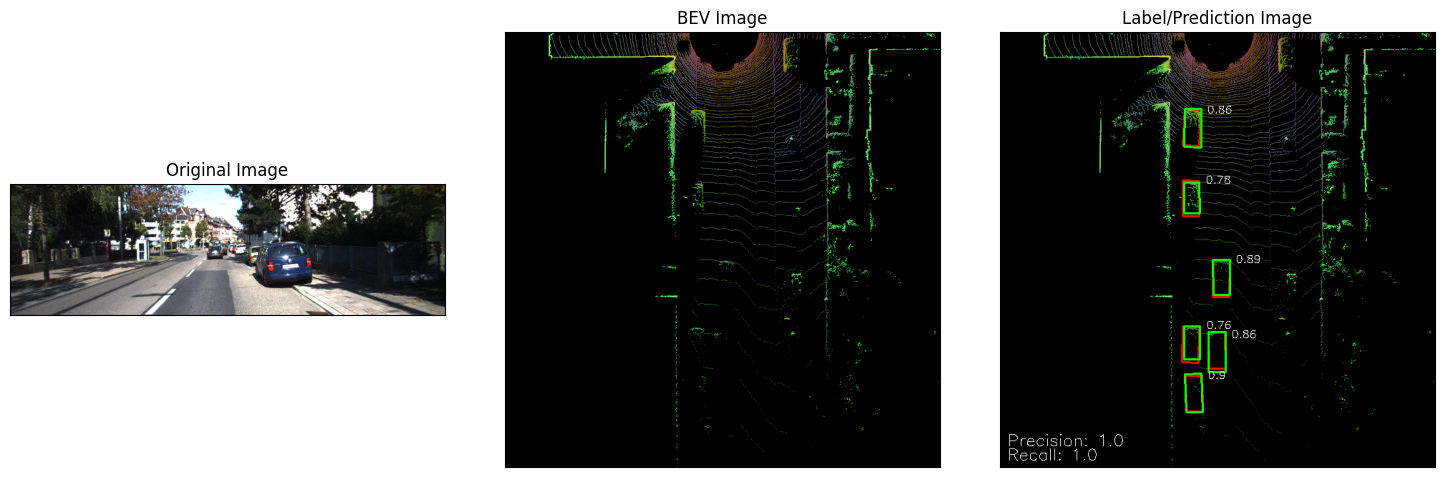

In [11]:
# Load up an image, labels, output and its BEV data
image_number = "006253"

label_bev = cv2.imread(f"KITTI/labels_output/{image_number}.png")
sample_img = cv2.imread(f"KITTI/images/{image_number}.png")
sample_bev = cv2.imread(f"KITTI/bev/{image_number}.png")
sample_full = cv2.imread(f"KITTI/full_output/{image_number}.png")

# Create a figure and axes 
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Subplot 1
axes[0].imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original Image")
# Subplot 2
axes[1].imshow(cv2.cvtColor(sample_bev, cv2.COLOR_BGR2RGB))
axes[1].set_title("BEV Image")
# Subplot 3
axes[2].imshow(cv2.cvtColor(label_bev, cv2.COLOR_BGR2RGB))
axes[2].set_title("Label/Prediction Image")

# Adjust layout to prevent clipping of titles
plt.tight_layout()
# Show the plot
for i in range(3):
    axes[i].set_yticks([])
    axes[i].set_xticks([])
plt.show()